In [127]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
%autoreload 2

In [152]:
from master import *
from models import *
from torchsummary import summary

In [153]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
ROOT_DIR = '/beegfs/bva212/fma_small_cqt/'
PATH_FILE = 'checksums'
BATCH_SIZE = 32
VAL_SPLIT = 0.2
TRANSFORM_PROB  = 0.5
SR = 22050
MODEL_SAVE_PATH = '/beegfs/sc6957/audionet_jigsaw_model.pth'
MODE = 'jigsaw'
MODEL_ARCHITECTURE = 'snet'  #['l3net','snet','anet']
SEPARABLE = True
REDUCE_TWO_CLASS = True #Applies to jigsaw (6-class to 2-class)
NUM_SECONDS=10

cuda:0


In [154]:
start = time.time()
MODEL = load_model(DEVICE, MODEL_ARCHITECTURE, MODE, SEPARABLE)
master = Master(DEVICE, ROOT_DIR, PATH_FILE, SR, BATCH_SIZE, VAL_SPLIT, TRANSFORM_PROB, REDUCE_TWO_CLASS, MODE, MODEL, NUM_SECONDS)
print(f'time for instantiating audio net object - {time.time() - start}')

Instantiating Model snet_jigsaw_separable
MODE: jigsaw
Getting Train & Validation Datasets
Excluding these 3 files - ['098/098567.mp3_cqt.npy', '098/098565.mp3_cqt.npy', '098/098569.mp3_cqt.npy']
There are a total of 7836 music files in the root directory
# Training samples: 6268 	 # Validation samples: 1567
	 --Done
Creating Train & Validation Dataloaders
Length of Train dataloader: 196 	 Validation dataloader: 49
	 --Done
	 --Done
Init actions done
time for instantiating audio net object - 1.796952724456787


In [155]:
master.model

DataParallel(
  (module): snet_jigsaw_separable(
    (conv_layers): Sequential(
      (0): Conv2d(3, 3, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4), groups=3)
      (1): Conv2d(3, 16, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1))
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=4, stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
      (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=3, stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3))
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2,

In [156]:
master.input_size

torch.Size([3, 84, 135])

In [157]:
summary(master.model,input_size=master.input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 44, 70]              78
            Conv2d-2           [-1, 16, 23, 36]              64
       BatchNorm2d-3           [-1, 16, 23, 36]              32
              ReLU-4           [-1, 16, 23, 36]               0
         MaxPool2d-5           [-1, 16, 20, 17]               0
            Conv2d-6           [-1, 32, 12, 11]          12,832
       BatchNorm2d-7           [-1, 32, 12, 11]              64
              ReLU-8           [-1, 32, 12, 11]               0
         MaxPool2d-9            [-1, 32, 10, 5]               0
           Conv2d-10             [-1, 64, 7, 4]          32,832
      BatchNorm2d-11             [-1, 64, 7, 4]             128
             ReLU-12             [-1, 64, 7, 4]               0
           Conv2d-13            [-1, 128, 5, 4]         131,200
      BatchNorm2d-14            [-1, 12

Instantiating Optimzer, Loss Criterion, Scheduler
	 --Done
Training started
Epoch 1/10
----------
Phase: train   Iteration 196/196
train Loss: 0.7013 Acc: 0.5243
Phase: valid   Iteration 49/49
valid Loss: 0.7403 Acc: 0.5271

Successfully checkpointed model after 0 epochs
Epoch 5/10id   Iteration 49/4996
----------
Phase: train   Iteration 196/196
train Loss: 0.6892 Acc: 0.5354
Phase: valid   Iteration 49/49
valid Loss: 0.6761 Acc: 0.5495

Successfully checkpointed model after 5 epochs
Epoch 9/10id   Iteration 49/4996
----------
Phase: train   Iteration 196/196
train Loss: 0.6764 Acc: 0.5614
Phase: valid   Iteration 49/49
valid Loss: 0.6826 Acc: 0.5520

Training time: 3minutes 33.923808336257935s
Best val Acc: 0.593491


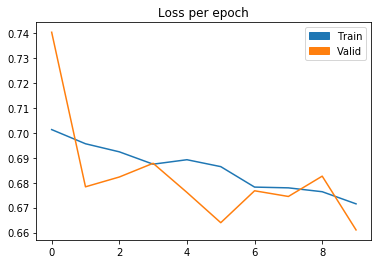

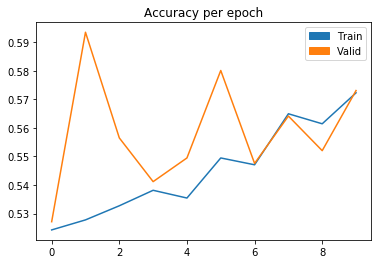

In [159]:
master.train(num_epochs= 10, learning_rate=1e-4, print_every=4, verbose=True, save=True, checkpoint_every=5)

In [ ]:
start = time.time()
batch = next(iter(master.dataloaders['train']))
print(f'time for fetching one batch - {time.time() - start}')

In [79]:
batch[0].shape,batch[1].shape

(torch.Size([32, 3, 84, 135]), torch.Size([32]))